# Convert and Optimize YOLOv8 with OpenVINO™

The YOLOv8 algorithm developed by Ultralytics is a cutting-edge, state-of-the-art (SOTA) model that is designed to be fast, accurate, and easy to use, making it an excellent choice for a wide range of object detection, image segmentation, and image classification tasks.

YOLO stands for “You Only Look Once”, it is a popular family of real-time object detection algorithms. 
The original YOLO object detector was first released in 2016. Since then, different versions and variants of YOLO have been proposed, each providing a significant increase in performance and efficiency.
YOLOv8 builds upon the success of previous YOLO versions and introduces new features and improvements to further boost performance and flexibility.
More details about its realization can be found in the original model [repository](https://github.com/ultralytics/ultralytics).

Real-time object detection and instance segmentation are often used as key components in computer vision systems. 
Applications that use real-time object detection models include video analytics, robotics, autonomous vehicles, multi-object tracking and object counting, medical image analysis, and many others.


This tutorial demonstrates step-by-step instructions on how to run and optimize PyTorch YOLOv8 with OpenVINO. We consider the steps required for object detection and instance segmentation scenarios.

The tutorial consists of the following steps:

- Prepare the PyTorch model.
- Download and prepare a dataset.
- Validate the original model.
- Convert the PyTorch model to OpenVINO IR.
- Validate the converted model.
- Prepare and run optimization pipeline.
- Compare performance of the FP32 and quantized models.
- Compare accuracy of the FP32 and quantized models.


<a id="0"></a>
### Table of content:
- [Get Pytorch model](#1)
        - [Prerequisites](#2)
- [Instantiate model](#3)
    - [Object detection](#4)
    - [Instance Segmentation:](#5)
    - [Convert model to OpenVINO IR](#6)
    - [Verify model inference](#7)
    - [Preprocessing](#8)
    - [Postprocessing](#9)
    - [Select inference device](#10)
    - [Test on single image](#11)
    - [Check model accuracy on the dataset](#12)
        - [Download the validation dataset](#13)
        - [Define validation function](#14)
        - [Configure Validator helper and create DataLoader](#15)
    - [Optimize model using NNCF Post-training Quantization API](#16)
    - [Validate Quantized model inference](#17)
        - [Object detection:](#18)
        - [Instance segmentation:](#19)
    - [Compare Performance of the Original and Quantized Models](#20)
        - [Compare performance object detection models](#21)
        - [Instance segmentation](#22)
    - [Validate quantized model accuracy](#23)
        - [Object detection](#24)
        - [Instance segmentation](#25)
- [Next steps](#26)
    - [Async inference pipeline](#27)
    - [Integration preprocessing to model](#28)
        - [Initialize PrePostProcessing API](#29)
        - [Define input data format](#30)
        - [Describe preprocessing steps](#31)
        - [Integrating Steps into a Model](#32)
    - [Live demo](#33)
    - [Run](#34)
        - [Run Live Object Detection and Segmentation](#35)

<a id="1"></a>
## Get Pytorch model [&#8657;](#0)

Generally, PyTorch models represent an instance of the [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class, initialized by a state dictionary with model weights.
We will use the YOLOv8 nano model (also known as `yolov8n`) pre-trained on a COCO dataset, which is available in this [repo](https://github.com/ultralytics/ultralytics). Similar steps are also applicable to other YOLOv8 models.
Typical steps to obtain a pre-trained model:

1. Create an instance of a model class.
2. Load a checkpoint state dict, which contains the pre-trained model weights.
3. Turn the model to evaluation for switching some operations to inference mode.

In this case, the creators of the model provide an API that enables converting the YOLOv8 model to ONNX and then to OpenVINO IR. Therefore, we do not need to do these steps manually.

<a id="2"></a>
#### Prerequisites [&#8657;](#0)

Install necessary packages.

In [1]:
# !pip install -q "openvino-dev>=2023.0.0" "nncf>=2.5.0"
# !pip install -q "ultralytics==8.0.43" onnx

Import required utility functions.
The lower cell will download the `notebook_utils` Python module from GitHub.

In [4]:
from pathlib import Path

# Fetch the notebook utils script from the openvino_notebooks repo
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)

from notebook_utils import download_file, VideoPlayer

Define utility functions for drawing results

In [2]:
from typing import Tuple, Dict
import cv2
import numpy as np
from PIL import Image
from ultralytics.yolo.utils.plotting import colors


def plot_one_box(box:np.ndarray, img:np.ndarray, color:Tuple[int, int, int] = None, mask:np.ndarray = None, label:str = None, line_thickness:int = 5):
    """
    Helper function for drawing single bounding box on image
    Parameters:
        x (np.ndarray): bounding box coordinates in format [x1, y1, x2, y2]
        img (no.ndarray): input image
        color (Tuple[int, int, int], *optional*, None): color in BGR format for drawing box, if not specified will be selected randomly
        mask (np.ndarray, *optional*, None): instance segmentation mask polygon in format [N, 2], where N - number of points in contour, if not provided, only box will be drawn
        label (str, *optonal*, None): box label string, if not provided will not be provided as drowing result
        line_thickness (int, *optional*, 5): thickness for box drawing lines
    """
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    if mask is not None:
        image_with_mask = img.copy()
        mask
        cv2.fillPoly(image_with_mask, pts=[mask.astype(int)], color=color)
        img = cv2.addWeighted(img, 0.5, image_with_mask, 0.5, 1)
    return img


def draw_results(results:Dict, source_image:np.ndarray, label_map:Dict):
    """
    Helper function for drawing bounding boxes on image
    Parameters:
        image_res (np.ndarray): detection predictions in format [x1, y1, x2, y2, score, label_id]
        source_image (np.ndarray): input image for drawing
        label_map; (Dict[int, str]): label_id to class name mapping
    Returns:
        
    """
    boxes = results["det"]
    masks = results.get("segment")
    h, w = source_image.shape[:2]
    for idx, (*xyxy, conf, lbl) in enumerate(boxes):
        label = f'{label_map[int(lbl)]} {conf:.2f}'
        mask = masks[idx] if masks is not None else None
        source_image = plot_one_box(xyxy, source_image, mask=mask, label=label, color=colors(int(lbl)), line_thickness=1)
    return source_image

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")



In [5]:
# Download a test sample
IMAGE_PATH = Path('./data/coco_bike.jpg')
download_file(
    url='https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_bike.jpg',
    filename=IMAGE_PATH.name,
    directory=IMAGE_PATH.parent
) 

data/coco_bike.jpg:   0%|          | 0.00/182k [00:00<?, ?B/s]

PosixPath('/home/flor/Desktop/git_repos/YOLO-OpenVINO-TVM-GStreamer/004-Optimization-with-OpenVINO/data/coco_bike.jpg')

<a id="3"></a>
## Instantiate model [&#8657;](#0)

There are several models available in the original repository, targeted for different tasks. For loading the model, required to specify a path to the model checkpoint. It can be some local path or name available on models hub (in this case model checkpoint will be downloaded automatically). 

Making prediction, the model accepts a path to input image and returns list with Results class object. Results contains boxes for object detection model and boxes and masks for segmentation model. Also it contains utilities for processing results, for example, `plot()` method for drawing.

Let us consider the examples:

In [6]:
import os
base_dir = os.path.dirname(os.getcwd())
models_dir = os.path.join(base_dir, "002-Training-models/train_results/chosen_models")
foldername = "model_yolov8_tf_yolov8m_imgsz_640_epochs_100_batch_16_dataset_v2_loss_SGD_lr_01"
weights_dir = os.path.join(models_dir, foldername, "weights")


<a id="4"></a>
### Object detection [&#8657;](#0)



image 1/1 /home/flor/Desktop/git_repos/YOLO-OpenVINO-TVM-GStreamer/004-Optimization-with-OpenVINO/data/coco_bike.jpg: 416x640 1 gun, 458.1ms
Speed: 1.0ms preprocess, 458.1ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


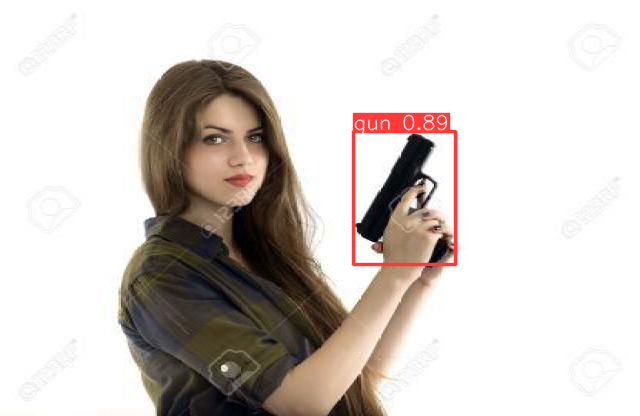

In [9]:
from ultralytics import YOLO

DET_MODEL_NAME = "best"

det_model = YOLO(f'{weights_dir}/{DET_MODEL_NAME}.pt')
label_map = det_model.model.names

res = det_model(IMAGE_PATH)
Image.fromarray(res[0].plot()[:, :, ::-1])

<a id="6"></a>
### Convert model to OpenVINO IR [&#8657;](#0)

YOLOv8 provides API for convenient model exporting to different formats including OpenVINO IR. `model.export` is responsible for model conversion. We need to specify the format, and additionally, we can preserve dynamic shapes in the model.

In [11]:
# object detection model
det_model_path = Path(f"{weights_dir}/{DET_MODEL_NAME}_openvino_model/{DET_MODEL_NAME}.xml")
if not det_model_path.exists():
    det_model.export(format="openvino", dynamic=True, half=False)

<a id="7"></a>
### Verify model inference [&#8657;](#0)

To test model work, we create inference pipeline similar to `model.predict` method. The pipeline consists of preprocessing step, inference of OpenVINO model and results post-processing to get results.
The main difference in models for object detection and instance segmentation is postprocessing part. Input specification and preprocessing are common for both cases.

<a id="8"></a>
### Preprocessing [&#8657;](#0)

Model input is a tensor with the `[-1, 3, -1, -1]` shape in the `N, C, H, W` format, where

* `N` - number of images in batch (batch size)
* `C` - image channels
* `H` - image height
* `W` - image width

The model expects images in RGB channels format and normalized in [0, 1] range. Although the model supports dynamic input shape with preserving input divisibility to 32, it is recommended to use static shapes, for example, 640x640 for better efficiency. To resize images to fit model size `letterbox`, resize approach is used, where the aspect ratio of width and height is preserved.

To keep a specific shape, preprocessing automatically enables padding.

In [12]:
from typing import Tuple
from ultralytics.yolo.utils import ops
import torch
import numpy as np


def letterbox(img: np.ndarray, new_shape:Tuple[int, int] = (640, 640), color:Tuple[int, int, int] = (114, 114, 114), auto:bool = False, scale_fill:bool = False, scaleup:bool = False, stride:int = 32):
    """
    Resize image and padding for detection. Takes image as input, 
    resizes image to fit into new shape with saving original aspect ratio and pads it to meet stride-multiple constraints
    
    Parameters:
      img (np.ndarray): image for preprocessing
      new_shape (Tuple(int, int)): image size after preprocessing in format [height, width]
      color (Tuple(int, int, int)): color for filling padded area
      auto (bool): use dynamic input size, only padding for stride constrins applied
      scale_fill (bool): scale image to fill new_shape
      scaleup (bool): allow scale image if it is lower then desired input size, can affect model accuracy
      stride (int): input padding stride
    Returns:
      img (np.ndarray): image after preprocessing
      ratio (Tuple(float, float)): hight and width scaling ratio
      padding_size (Tuple(int, int)): height and width padding size
    
    
    """
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scale_fill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)


def preprocess_image(img0: np.ndarray):
    """
    Preprocess image according to YOLOv8 input requirements. 
    Takes image in np.array format, resizes it to specific size using letterbox resize and changes data layout from HWC to CHW.
    
    Parameters:
      img0 (np.ndarray): image for preprocessing
    Returns:
      img (np.ndarray): image after preprocessing
    """
    # resize
    img = letterbox(img0)[0]
    
    # Convert HWC to CHW
    img = img.transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    return img


def image_to_tensor(image:np.ndarray):
    """
    Preprocess image according to YOLOv8 input requirements. 
    Takes image in np.array format, resizes it to specific size using letterbox resize and changes data layout from HWC to CHW.
    
    Parameters:
      img (np.ndarray): image for preprocessing
    Returns:
      input_tensor (np.ndarray): input tensor in NCHW format with float32 values in [0, 1] range 
    """
    input_tensor = image.astype(np.float32)  # uint8 to fp32
    input_tensor /= 255.0  # 0 - 255 to 0.0 - 1.0
    
    # add batch dimension
    if input_tensor.ndim == 3:
        input_tensor = np.expand_dims(input_tensor, 0)
    return input_tensor

WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")



<a id="9"></a>
### Postprocessing [&#8657;](#0)

The model output contains detection boxes candidates, it is a tensor with the `[-1,84,-1]` shape in the `B,84,N` format, where:

- `B` - batch size
- `N` - number of detection boxes

Detection box has the [`x`, `y`, `h`, `w`, `class_no_1`, ..., `class_no_80`] format, where:

- (`x`, `y`) - raw coordinates of box center
- `h`, `w` - raw height and width of the box
- `class_no_1`, ..., `class_no_80` - probability distribution over the classes.

For getting the final prediction, we need to apply a non-maximum suppression algorithm and rescale box coordinates to the original image size.

The instance segmentation model, additionally, has an output that contains proto mask candidates for instance segmentation. It should be decoded by using box coordinates. It is a tensor with the `[-1 32, -1, -1]` shape in the `B,C H,W` format, where:

- `B` - batch size
- `C` - number of candidates
- `H` - mask height
- `W` - mask width

In [16]:
try:
    scale_segments = ops.scale_segments
except AttributeError:
    scale_segments = ops.scale_coords

def postprocess(
    pred_boxes:np.ndarray, 
    input_hw:Tuple[int, int], 
    orig_img:np.ndarray, 
    min_conf_threshold:float = 0.25, 
    nms_iou_threshold:float = 0.7, 
    agnosting_nms:bool = False, 
    max_detections:int = 300,
    pred_masks:np.ndarray = None,
    retina_mask:bool = False
):
    """
    YOLOv8 model postprocessing function. Applied non maximum supression algorithm to detections and rescale boxes to original image size
    Parameters:
        pred_boxes (np.ndarray): model output prediction boxes
        input_hw (np.ndarray): preprocessed image
        orig_image (np.ndarray): image before preprocessing
        min_conf_threshold (float, *optional*, 0.25): minimal accepted confidence for object filtering
        nms_iou_threshold (float, *optional*, 0.45): minimal overlap score for removing objects duplicates in NMS
        agnostic_nms (bool, *optiona*, False): apply class agnostinc NMS approach or not
        max_detections (int, *optional*, 300):  maximum detections after NMS
        pred_masks (np.ndarray, *optional*, None): model ooutput prediction masks, if not provided only boxes will be postprocessed
        retina_mask (bool, *optional*, False): retina mask postprocessing instead of native decoding
    Returns:
       pred (List[Dict[str, np.ndarray]]): list of dictionary with det - detected boxes in format [x1, y1, x2, y2, score, label] and segment - segmentation polygons for each element in batch
    """
    nms_kwargs = {"agnostic": agnosting_nms, "max_det":max_detections}
    # if pred_masks is not None:
    #     nms_kwargs["nm"] = 32
    preds = ops.non_max_suppression(
        torch.from_numpy(pred_boxes),
        min_conf_threshold,
        nms_iou_threshold,
        nc=1,
        **nms_kwargs
    )
    results = []
    proto = torch.from_numpy(pred_masks) if pred_masks is not None else None

    for i, pred in enumerate(preds):
        shape = orig_img[i].shape if isinstance(orig_img, list) else orig_img.shape
        if not len(pred):
            results.append({"det": [], "segment": []})
            continue
        if proto is None:
            pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
            results.append({"det": pred})
            continue
        if retina_mask:
            pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
            masks = ops.process_mask_native(proto[i], pred[:, 6:], pred[:, :4], shape[:2])  # HWC
            segments = [scale_segments(input_hw, x, shape, normalize=False) for x in ops.masks2segments(masks)]
        else:
            masks = ops.process_mask(proto[i], pred[:, 6:], pred[:, :4], input_hw, upsample=True)
            pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
            segments = [scale_segments(input_hw, x, shape, normalize=False) for x in ops.masks2segments(masks)]
        results.append({"det": pred[:, :6].numpy(), "segment": segments})
    return results

<a id="10"></a>
### Select inference device [&#8657;](#0)

select device from dropdown list for running inference using OpenVINO

In [17]:
import ipywidgets as widgets
from openvino.runtime import Core

core = Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

<a id="11"></a>
### Test on single image [&#8657;](#0)

Now, once we have defined preprocessing and postprocessing steps, we are ready to check model prediction.

First, object detection:

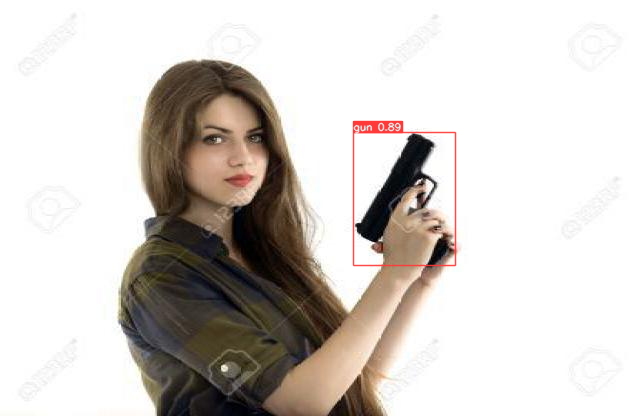

In [18]:
from openvino.runtime import Core, Model

core = Core()
det_ov_model = core.read_model(det_model_path)
if device.value != "CPU":
    det_ov_model.reshape({0: [1, 3, 640, 640]})
det_compiled_model = core.compile_model(det_ov_model, device.value)


def detect(image:np.ndarray, model:Model):
    """
    OpenVINO YOLOv8 model inference function. Preprocess image, runs model inference and postprocess results using NMS.
    Parameters:
        image (np.ndarray): input image.
        model (Model): OpenVINO compiled model.
    Returns:
        detections (np.ndarray): detected boxes in format [x1, y1, x2, y2, score, label]
    """
    num_outputs = len(model.outputs)
    preprocessed_image = preprocess_image(image)
    input_tensor = image_to_tensor(preprocessed_image)
    result = model(input_tensor)
    boxes = result[model.output(0)]
    masks = None
    if num_outputs > 1:
        masks = result[model.output(1)]
    input_hw = input_tensor.shape[2:]
    detections = postprocess(pred_boxes=boxes, input_hw=input_hw, orig_img=image, pred_masks=masks)
    return detections


input_image = np.array(Image.open(IMAGE_PATH))
detections = detect(input_image, det_compiled_model)[0]
image_with_boxes = draw_results(detections, input_image, label_map)

Image.fromarray(image_with_boxes)